In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Read samples from one station

In [4]:
station_code = 'SONDOC'

value_field = 'max'

#### Read true raw samples

In [5]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [6]:
df.set_index('date', inplace=True)

In [7]:
df = df[df['code'] == station_code]

In [8]:
# How samples distributed
df.groupby(df.index.year).count()

,code,min,max,x,y,cm
date,,,,,,
2002,181,181,181,181,181,181
2003,181,181,181,181,181,181
2004,182,182,182,182,182,182
2005,181,181,181,181,181,181
2006,181,181,181,181,181,181
2007,181,181,181,181,181,181
2008,182,182,182,182,182,182
2009,181,181,181,181,181,181
2010,181,181,181,181,181,181


From 2002 to 2010, samples are completed for dry seasons: 181 for normal years; 182 for leap years (January to June)

2011 and 2018 have samples from January to May (151 days)

2012 to 2016 have less samples, missing dates

2017 has no samples at all

#### Reread prepared train samples

In [9]:
train_df = pd.read_csv(f'../../dataset/final/tops/{station_code}.csv', parse_dates=['date'])

In [10]:
# set index to time-series based 'date'
train_df.set_index('date', inplace=True)

In [11]:
train_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', name='date', length=3287, freq=None)

In [12]:
# can not set index frequency to D - daily due to missing discontinuous timestamps in the dataset
train_df.index.freq = 'D'
train_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', name='date', length=3287, freq='D')

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2002-01-01 to 2010-12-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    3287 non-null   object 
 1   min     3287 non-null   float64
 2   max     3287 non-null   float64
dtypes: float64(2), object(1)
memory usage: 102.7+ KB


In [14]:
# sort by date index
train_df.sort_index(inplace=True)

In [15]:
train_data = train_df[value_field]

In [16]:
train_data.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', name='date', length=3287, freq='D')

In [17]:
train_data.head()

date
2002-01-01   0.30000
2002-01-02   0.40000
2002-01-03   0.40000
2002-01-04   0.50000
2002-01-05   0.60000
Freq: D, Name: max, dtype: float64

In [18]:
train_data.tail()

date
2010-12-27   3.50000
2010-12-28   3.60000
2010-12-29   3.40000
2010-12-30   3.90000
2010-12-31   4.50000
Freq: D, Name: max, dtype: float64

### ARIMA Self Help

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

#### Reread prepared test samples
Use 2011

In [21]:
test_year = 2011

In [22]:
test_df = pd.read_csv(f'../../dataset/final/stations/{station_code}.csv', parse_dates=['date'])

In [23]:
test_df.set_index('date', inplace=True)

In [24]:
test_df = test_df[test_df.index.year == test_year]
test_df = test_df[f'{test_year}-01-01':f'{test_year}-05-31']
test_df.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2011-05-22', '2011-05-23', '2011-05-24', '2011-05-25',
               '2011-05-26', '2011-05-27', '2011-05-28', '2011-05-29',
               '2011-05-30', '2011-05-31'],
              dtype='datetime64[ns]', name='date', length=151, freq=None)

In [25]:
test_df.index.freq = 'D'
test_df.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2011-05-22', '2011-05-23', '2011-05-24', '2011-05-25',
               '2011-05-26', '2011-05-27', '2011-05-28', '2011-05-29',
               '2011-05-30', '2011-05-31'],
              dtype='datetime64[ns]', name='date', length=151, freq='D')

In [26]:
test_data = test_df[value_field]

In [27]:
test_data.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2011-05-22', '2011-05-23', '2011-05-24', '2011-05-25',
               '2011-05-26', '2011-05-27', '2011-05-28', '2011-05-29',
               '2011-05-30', '2011-05-31'],
              dtype='datetime64[ns]', name='date', length=151, freq='D')

In [28]:
test_data.head()

date
2011-01-01   0.40000
2011-01-02   0.50000
2011-01-03   0.70000
2011-01-04   0.80000
2011-01-05   1.10000
Freq: D, Name: max, dtype: float64

In [29]:
test_data.tail()

date
2011-05-27   1.60000
2011-05-28   1.70000
2011-05-29   1.50000
2011-05-30   1.40000
2011-05-31   1.50000
Freq: D, Name: max, dtype: float64

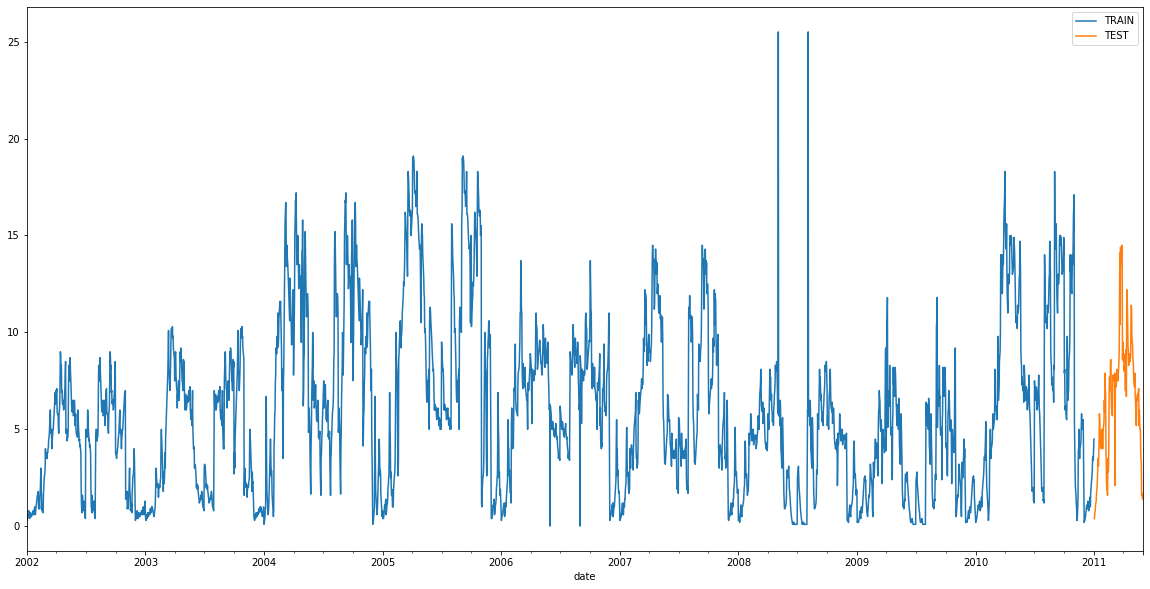

In [81]:
train_data.plot(legend=True, label='TRAIN')
test_data.plot(legend=True, label='TEST', figsize=(20,10))

### Try out some simpler models

In [31]:
# seasonal adjustment
adjustment = 'additive'
#adjustment = 'multiplicative'

In [32]:
# Annual
season_length = test_data.shape[0]  # same length of test data

season_length

151

1. Holt-Winters method via Exponential Smoothing

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train_data, 
                                trend=adjustment, seasonal=adjustment, 
                                seasonal_periods=season_length).fit()

/home/kenneth/anaconda3/envs/salinization/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [34]:
hw_prediction = hw_model.forecast(season_length)

In [35]:
hw_prediction.head(10)

2011-01-01   4.39336
2011-01-02   3.91025
2011-01-03   3.98219
2011-01-04   3.76214
2011-01-05   3.27103
2011-01-06   3.28394
2011-01-07   2.89134
2011-01-08   2.80246
2011-01-09   3.22091
2011-01-10   3.49641
Freq: D, dtype: float64

In [36]:
hw_prediction.tail(10)

2011-05-22   4.98516
2011-05-23   4.76432
2011-05-24   4.85672
2011-05-25   4.62945
2011-05-26   4.32085
2011-05-27   4.20115
2011-05-28   3.73543
2011-05-29   4.02455
2011-05-30   4.37994
2011-05-31   4.44811
Freq: D, dtype: float64

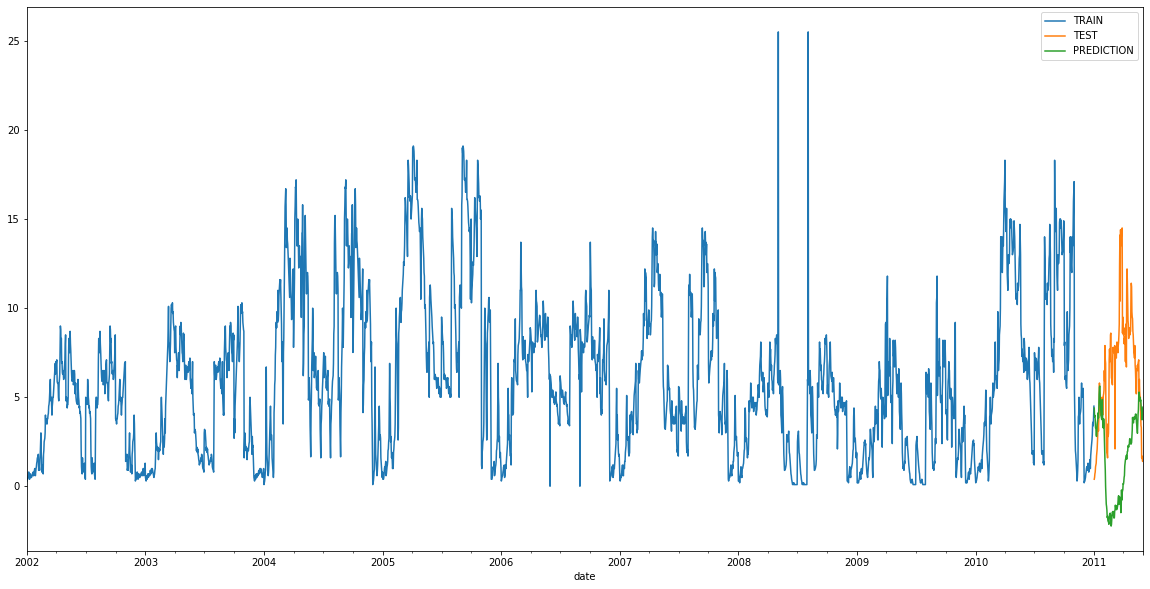

In [82]:
# plot prediction vs. true values
train_data.plot(legend=True, label='TRAIN')
test_data.plot(legend=True, label='TEST')
hw_prediction.plot(legend=True, label='PREDICTION', figsize=(20, 10));

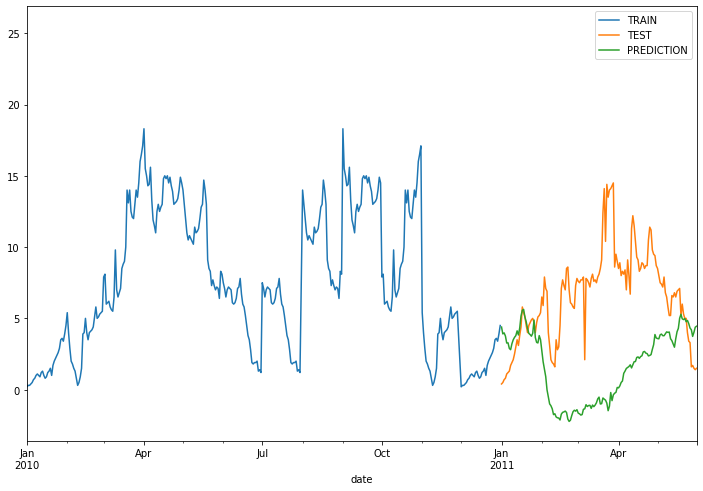

In [38]:
# plot prediction vs. true values on test set (zoomed version)
train_data.plot(legend=True, label='TRAIN')
test_data.plot(legend=True, label='TEST', figsize=(12,8))

hw_prediction.plot(legend=True, label='PREDICTION', xlim=[f'{test_year - 1}-01-01', f'{test_year}-05-31']);

#### Evaluating Prediction against test set

In [39]:
# Option 1: use scikit-learns implementations
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
test_data.describe()

count   151.00000
mean      6.59139
std       3.18745
min       0.40000
25%       4.50000
50%       7.00000
75%       8.50000
max      14.50000
Name: max, dtype: float64

In [41]:
hw_prediction.describe()

count   151.00000
mean      1.66265
std       2.43181
min      -2.22845
25%      -1.00158
50%       2.32383
75%       3.81321
max       5.62872
dtype: float64

The average of test data value is: 6.60 while the average of prediction value is: 1.66  

In [42]:
mae = mean_absolute_error(test_data, hw_prediction)

mae

5.527193758294633

In [43]:
mse = mean_squared_error(test_data, hw_prediction)

mse

45.47966783264434

In [44]:
rmse = np.sqrt(mse)

rmse

6.7438614926942515

##### Holt-Winters prediction is so bad
rmse = 6.74 vs. test data STD = 3.19: Error in form of RMSE is about 211% of Test STD => TOO BAD

2. Other simple model goes here

### ARIMA models

1. Using AR component

In [45]:
from statsmodels.tsa.ar_model import AR, ARResults

In [46]:
model = AR(train_data)

ARfit = model.fit(method='mle', ic='t-stat')

lags = ARfit.k_ar

print(f'Lag: {lags}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 28
Coefficients:
const      0.13779
L1.max     0.87222
L2.max     0.07354
L3.max    -0.03491
L4.max    -0.00315
L5.max     0.01293
L6.max     0.00771
L7.max     0.00650
L8.max    -0.01006
L9.max     0.04184
L10.max   -0.03276
L11.max   -0.03009
L12.max    0.00399
L13.max    0.02702
L14.max    0.03285
L15.max   -0.01487
L16.max    0.01419
L17.max   -0.03710
L18.max   -0.01319
L19.max    0.00526
L20.max    0.00100
L21.max   -0.01447
L22.max    0.02269
L23.max    0.00227
L24.max    0.02283
L25.max   -0.02474
L26.max    0.02615
L27.max   -0.01932
L28.max    0.03742
dtype: float64


In [47]:
# general formula to calculate time periods for obtaining predictions
start = len(train_data)
end = start + len(test_data) - 1

In [48]:
start

3287

In [49]:
end

3437

In [50]:
ARprediction = ARfit.predict(start=start, end=end).rename(f'AR({lags}) Prediction')

In [51]:
ARprediction.head()

2011-01-01   4.34145
2011-01-02   4.21816
2011-01-03   4.07079
2011-01-04   3.98116
2011-01-05   3.91558
Freq: D, Name: AR(28) Prediction, dtype: float64

In [52]:
ARprediction.tail()

2011-05-27   5.12713
2011-05-28   5.13272
2011-05-29   5.13826
2011-05-30   5.14374
2011-05-31   5.14916
Freq: D, Name: AR(28) Prediction, dtype: float64

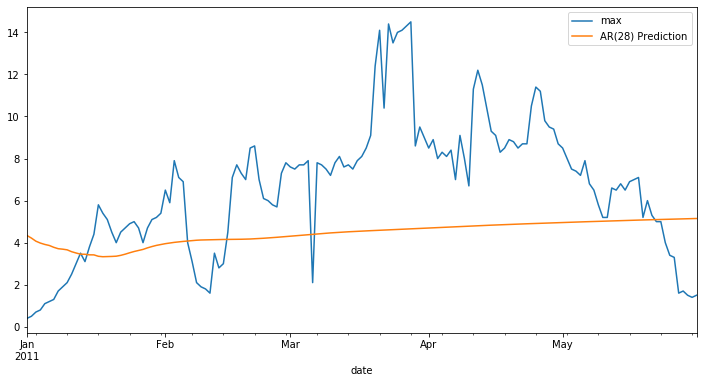

In [53]:
test_data.plot(legend=True)
ARprediction.plot(legend=True,figsize=(12,6));

AR only prediction is not bad since it can capture the mean of test data

#### Evaluating models

In [54]:
# Option 2: Use statsmodels implementations

from statsmodels.tools.eval_measures import mse, rmse, meanabs, aic, bic

In [55]:
mae = meanabs(test_data, ARprediction)

mae

3.0450420257639843

In [56]:
# Akaike information criterion (AIC)
# we seldom compute AIC alone as it is built into many of the statsmodels tools we use

In [57]:
# Bayesian information criterion (BIC)
# we seldom compute BIC alone as it is built into many of the statsmodels tools we use

2. Pyramid ARIMA aka Auto-ARIMA

In [58]:
from pmdarima import auto_arima

In [59]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima``

In [97]:
stepwise_fit = auto_arima(train_data, 
                          start_p=0, start_q=0,
                          max_p=6, max_q=6, 
                          m=12,                     # 6 months season
                          start_P=0, 
                          seasonal=True,
                          d=None, 
                          D=1, 
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 12) (constant=True); AIC=17132.027, BIC=17150.309, Time=1.101 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=17557.573, BIC=17569.761, Time=0.114 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=12269.281, BIC=12293.657, Time=1.928 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=14653.122, BIC=14677.498, Time=1.991 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=17555.590, BIC=17561.684, Time=0.085 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=13275.564, BIC=13293.846, Time=0.479 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 12) (constant=True); AIC=11934.112, BIC=11964.583, Time=7.453 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 12) (constant=True); AIC=11109.580, BIC=11146.144, Time=33.271 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit cir

In [98]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 3287
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -5540.403
Date:                              Thu, 12 Mar 2020   AIC                          11092.806
Time:                                      00:53:46   BIC                          11129.371
Sample:                                           0   HQIC                         11105.900
                                             - 3287                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.424e-06      0.000     -0.025      0.980      -0.001       0.001
ar.L1          0.8867      0.005    164.789      0.000       0.876       0.897
ar.L2          0.0717      0.006     11.732      0.000       0.060       0.084
ar.S.L12      -0.0313      0.015     -2.107      0.035      -0.060      -0.002
ma.S.L12      -0.9995      0.063    -15.919      0.000      -1.123      -0.876
sigma2         1.6912      0.102     16.579      0.000       1.491       1.891
===================================================================================
Ljung-Box (Q):                      188.55   Jarque-Bera (JB):            518025.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        64.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
from statsmodels.tsa.stattools import adfuller

In [63]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [64]:
# apply the first different
from statsmodels.tsa.statespace.tools import diff

In [65]:
diff1_df = diff(train_data, k_diff=1)

In [66]:
diff1_df.head()

date
2002-01-02   0.10000
2002-01-03   0.00000
2002-01-04   0.10000
2002-01-05   0.10000
2002-01-06   0.20000
Freq: D, Name: max, dtype: float64

In [67]:
adf_test(diff1_df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -13.86335
p-value                    0.00000
# lags used               29.00000
# observations         3,256.00000
critical value (1%)       -3.43236
critical value (5%)       -2.86243
critical value (10%)      -2.56724
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [91]:
# fit model
model = ARIMA(train_data, order=(3,1,1))
results = model.fit()

In [92]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.max   No. Observations:                 3286
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -5525.679
Method:                       css-mle   S.D. of innovations              1.300
Date:                Thu, 12 Mar 2020   AIC                          11063.357
Time:                        00:47:53   BIC                          11099.942
Sample:                    01-02-2002   HQIC                         11076.456
                         - 12-31-2010                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0009      0.011      0.082      0.935      -0.020       0.022
ar.L1.D.max     0.8067      0.024     33.923      0.000       0.760       0.853
ar.L2.D.max     0.0635      0.022      2.831      0.005       0.020       0.108
ar.L3.D.max    -0.0451      0.018     -2.484      0.013      -0.081      -0.010
ma.L1.D.max    -0.9167      0.016    -55.797      0.000      -0.949      -0.884
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2241           +0.0000j            1.2241            0.0000
AR.2           -4.1658           +0.0000j            4.1658            0.5000
AR.3            4.3520           +0.0000j            4.3520            0.0000
MA.1            1.0909           +0.0000j            1.0909            0.0000
-----------------------------------------------------------------------------
"""

In [93]:
# predict
predictions = results.predict(start=start, end=end,
                              dynamic=False,
                              typ='levels'  # linear: return in differences; levels: return in original form
                              ).rename('ARIMA Predictions')

In [94]:
predictions.head()

2011-01-01   4.32151
2011-01-02   4.19328
2011-01-03   4.05162
2011-01-04   3.93739
2011-01-05   3.84218
Freq: D, Name: ARIMA Predictions, dtype: float64

In [95]:
predictions.tail()

2011-05-27   3.53872
2011-05-28   3.53960
2011-05-29   3.54049
2011-05-30   3.54137
2011-05-31   3.54225
Freq: D, Name: ARIMA Predictions, dtype: float64

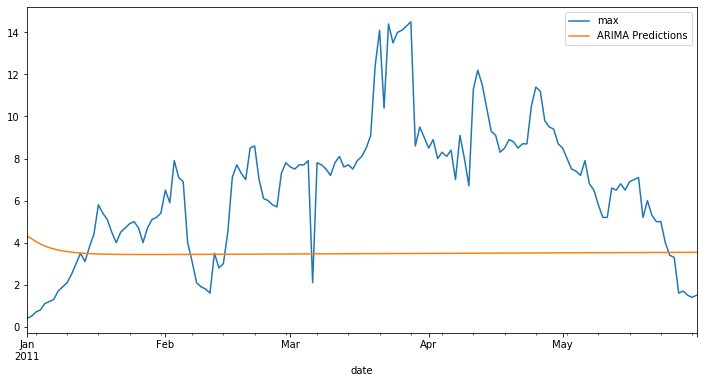

In [96]:
# plot
test_data.plot(legend=True)
predictions.plot(legend=True,figsize=(12,6));

3. Seasonal ARIMA

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [99]:
model = SARIMAX(train_data,order=(2,0,0),seasonal_order=(1,1,1,12))  # seasonal
#model = SARIMAX(train_data,order=(3,1,1))  # non seasonal
results = model.fit()

In [100]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  max   No. Observations:                 3287
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -5540.397
Date:                              Thu, 12 Mar 2020   AIC                          11090.795
Time:                                      00:55:31   BIC                          11121.265
Sample:                                  01-01-2002   HQIC                         11101.706
                                       - 12-31-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8868      0.004    201.444      0.000       0.878       0.895
ar.L2          0.0717      0.006     11.734      0.000       0.060       0.084
ar.S.L12      -0.0311      0.015     -2.095      0.036      -0.060      -0.002
ma.S.L12      -0.9999      0.383     -2.613      0.009      -1.750      -0.250
sigma2         1.6901      0.642      2.631      0.009       0.431       2.949
===================================================================================
Ljung-Box (Q):                      188.57   Jarque-Bera (JB):            518137.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        64.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
predictions = results.predict(start=start, end=end, 
                              dynamic=False,  # dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values). 
                              typ='levels'  # typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables
                             ).rename('SARIMAX Predictions')

In [102]:
predictions.head()

2011-01-01   4.38397
2011-01-02   4.50355
2011-01-03   4.59349
2011-01-04   4.63138
2011-01-05   4.61412
Freq: D, Name: SARIMAX Predictions, dtype: float64

In [103]:
predictions.tail()

2011-05-27   5.85955
2011-05-28   5.85039
2011-05-29   5.78978
2011-05-30   5.83584
2011-05-31   5.88621
Freq: D, Name: SARIMAX Predictions, dtype: float64

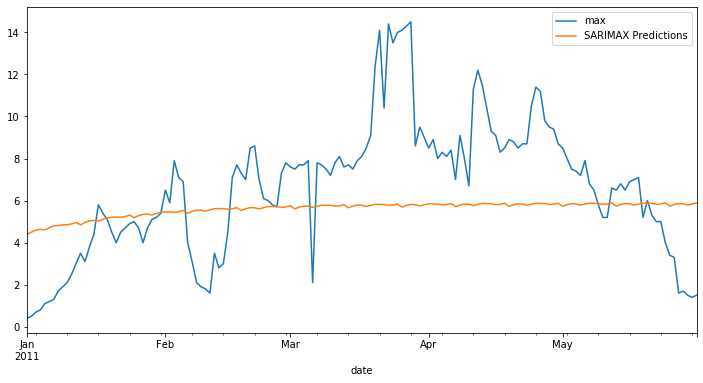

In [104]:
test_data.plot(legend=True)
predictions.plot(legend=True,figsize=(12,6));